# Setup Imports

In [4]:
# Setup
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from userdefinedmodels import *

# Setup Location and Weather

In [5]:
# evaluate hood river, oregon and key west, florida

# latitude, longitude, name, altitude, timezone
hood_river = (45.71417626139969, -121.5154782530592, 'Hood River', 27, 'Etc/GMT+8')
latitude, longitude, name, altitude, timezone = hood_river

location = Location(
    latitude,
    longitude,
    name=name,
    altitude=altitude,
    tz=timezone,
    )

times = pd.date_range('2019-01-01 00:00', '2019-01-01 23:59', freq='1s', tz=location.tz)
weather = location.get_clearsky(times)

## Sunrise Data

In [25]:
from pvlib.solarposition import sun_rise_set_transit_geometric, equation_of_time_analemma, declination_cooper69

# Calculate the day of the year
dayofyear = times.dayofyear

# Calculate declination and equation of time
declination = declination_cooper69(dayofyear)
equation_of_time = equation_of_time_analemma(dayofyear)

# Get sunrise, sunset, and transit times
sunrise, sunset, transit = sun_rise_set_transit_geometric(times, location.latitude, declination, equation_of_time)

# Print sunrise times
print(sunrise)

ImportError: cannot import name 'equation_of_time_analemma' from 'pvlib.solarposition' (/home/vscode/.local/lib/python3.12/site-packages/pvlib/solarposition.py)

# Setup System

## Module Parameters

In [6]:
# Get the module parameters from the CEC database
MODULE_24 = pvlib.pvsystem.retrieve_sam('CECMod')['JA_Solar_JAM5_L__72_200_SI']

# Copy the paramters we will need to a new dictionary
rich_solar_24V_params = {
    'Name' : 'Rich Solar 24V',
    'Technology': 'monoSI',
    'N_s' : MODULE_24['N_s'],
    'I_sc_ref' : MODULE_24['I_sc_ref'],
    'V_oc_ref' : MODULE_24['V_oc_ref'],
    'I_mp_ref' : MODULE_24['I_mp_ref'],
    'V_mp_ref' : MODULE_24['V_mp_ref'],
    'alpha_sc' : MODULE_24['alpha_sc'],
    'beta_oc' : MODULE_24['beta_oc'],
    'gamma_r' : MODULE_24['gamma_r'],
    'a_ref' : MODULE_24['a_ref'],
    'I_L_ref' : MODULE_24['I_L_ref'],
    'I_o_ref' : MODULE_24['I_o_ref'],
    'R_s' : MODULE_24['R_s'],
    'R_sh_ref' : MODULE_24['R_sh_ref'],
    'Adjust' : MODULE_24['Adjust']
}

## Temperature Parameters

In [7]:
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']


## Inverter Parameters
`v_batt`, `v_start`, `v_continue`, `r_batt_wire`, and `r_pv_wire`, are passed in a dict-like object via the PVSystem kwarg `inverter_parameters`.  

In [8]:
# Assume 20 ft of 10AGW wire on PV Side
r_batt_wire = getWireResistance('10AWG', 20)
# Assume 10 ft 10AGW wire on Battery Side
r_pv_wire = getWireResistance('10AWG', 10)

mppt_parameters = {
    'v_batt': 14.2,
    'v_start': 5.0,
    'v_continue': 1.0,
    'r_batt_wire': r_batt_wire,
    'r_pv_wire': r_pv_wire,
    'mppt_eff': 0.99
}

In [18]:

mount = FixedMount(
    surface_tilt=0,
    surface_azimuth=180,
    )
array = Array(
    mount=mount,
    module_parameters=rich_solar_24V_params,
    temperature_model_parameters=temperature_model_parameters,
    strings=1,
    modules_per_string=1,
    )

system = PVSystem(arrays=[array], 
                  inverter_parameters=mppt_parameters)

mc = ModelChain(system, 
                location, 
                aoi_model="physical", 
                spectral_model="no_loss", 
                dc_model="cec",
                ac_model=mppt,
                dc_ohmic_model=pv_wire_loss
                )

mc.run_model(weather)

# Get sunrise, sunset, and transit times
# Get sunrise, sunset, and transit times
sunrise, sunset, transit = location.get_sun_rise_set_transit(times, method='geometric')

# Print sunrise times
print(sunrise)
# Print sunrise times
print(sunrise)
    
#plot
plt.figure()
mc.results.dc['p_mp'].plot(title='DC Power (W)')
mc.results.ac.plot(label='MPPT Output (W)')
plt.legend()


TypeError: sun_rise_set_transit_geometric() missing 2 required positional arguments: 'declination' and 'equation_of_time'

Now lets figure out what results.dc really is

results.dc=
<class 'pandas.core.frame.DataFrame'>
                                   i_sc  v_oc          i_mp  v_mp  p_mp  \
2019-01-01 00:00:00-08:00  2.584939e-26   0.0  2.584939e-26   0.0   0.0   
2019-01-01 00:00:01-08:00  2.584939e-26   0.0  2.584939e-26   0.0   0.0   
2019-01-01 00:00:02-08:00  2.584939e-26   0.0  2.584939e-26   0.0   0.0   
2019-01-01 00:00:03-08:00  2.584939e-26   0.0  2.584939e-26   0.0   0.0   
2019-01-01 00:00:04-08:00  2.584939e-26   0.0  2.584939e-26   0.0   0.0   
...                                 ...   ...           ...   ...   ...   
2019-01-01 23:58:56-08:00  2.584939e-26   0.0  2.584939e-26   0.0   0.0   
2019-01-01 23:58:57-08:00  2.584939e-26   0.0  2.584939e-26   0.0   0.0   
2019-01-01 23:58:58-08:00  2.584939e-26   0.0  2.584939e-26   0.0   0.0   
2019-01-01 23:58:59-08:00  2.584939e-26   0.0  2.584939e-26   0.0   0.0   
2019-01-01 23:59:00-08:00  2.584939e-26   0.0  2.584939e-26   0.0   0.0   

                                    i_x          

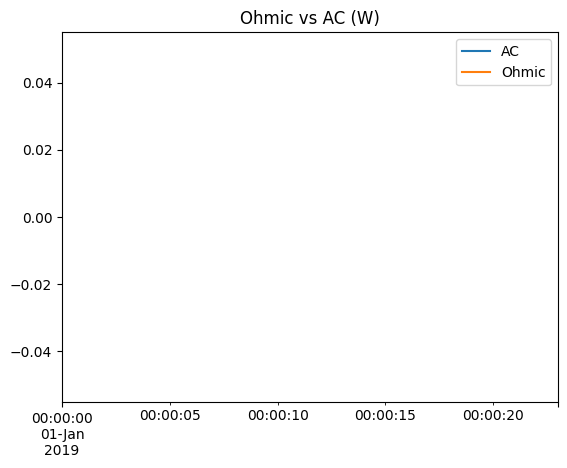

In [10]:
print('results.dc=')
print(type(mc.results.dc))
print(mc.results.dc)

print("results.dc['p_mp']=")
print(type(mc.results.dc['p_mp']))
print(mc.results.dc['p_mp'])    

print('results.ac=')
print(type(mc.results.ac))
print(mc.results.ac)

print('results.dc_ohmic_losses=')
print(type(mc.results.dc_ohmic_losses))
print(mc.results.dc_ohmic_losses)

print('ohmic vs ac=')
ohmic_vs_ac = pd.concat([mc.results.dc_ohmic_losses['p_pv_wire_loss'],
                         mc.results.dc_ohmic_losses['v_pv_wire_drop'],
                         mc.results.ac], axis=1)
print(ohmic_vs_ac)
#plot the first 24 hour period of ohmic vs ac
plt.figure()
ohmic_vs_ac['p_ac'].iloc[:24].div(ohmic_vs_ac['p_ac'].iloc[:24].max()).plot(title='Ohmic vs AC (W)', label='AC')
ohmic_vs_ac['p_pv_wire_loss'].iloc[:24].div(ohmic_vs_ac['p_pv_wire_loss'].iloc[:24].max()).plot(label='Ohmic')
plt.legend()

print(ohmic_vs_ac.iloc[:24])

In [11]:
a = [1, 2, 3, 4, 5]
b = [1, 2, 3, 4, 5]
points = a, b

print('points=', points)

points= ([1, 2, 3, 4, 5], [1, 2, 3, 4, 5])


In [12]:
inverter_params = {}
    # Defaulting parameters if not explicitly provided
mppt_eff = inverter_params.get('mppt_eff', 1.0)
r_batt_wire = inverter_params.get('r_batt_wire', 0)

print('mppt_eff=', mppt_eff)

mppt_eff= 1.0


In [13]:
def calculate_i_out(p_mppt_out):
    v_batt = 14.2 # volts
    r_batt_wire = 0.001 # ohms
    if r_batt_wire == 0:
        return p_mppt_out/v_batt
    else:
        return (-1*v_batt + np.sqrt(v_batt**2 + 4*p_mppt_out*r_batt_wire))/(2*r_batt_wire)
    
print('calculate_i_out(200)=', calculate_i_out(200))

calculate_i_out(200)= 14.070564732964641
